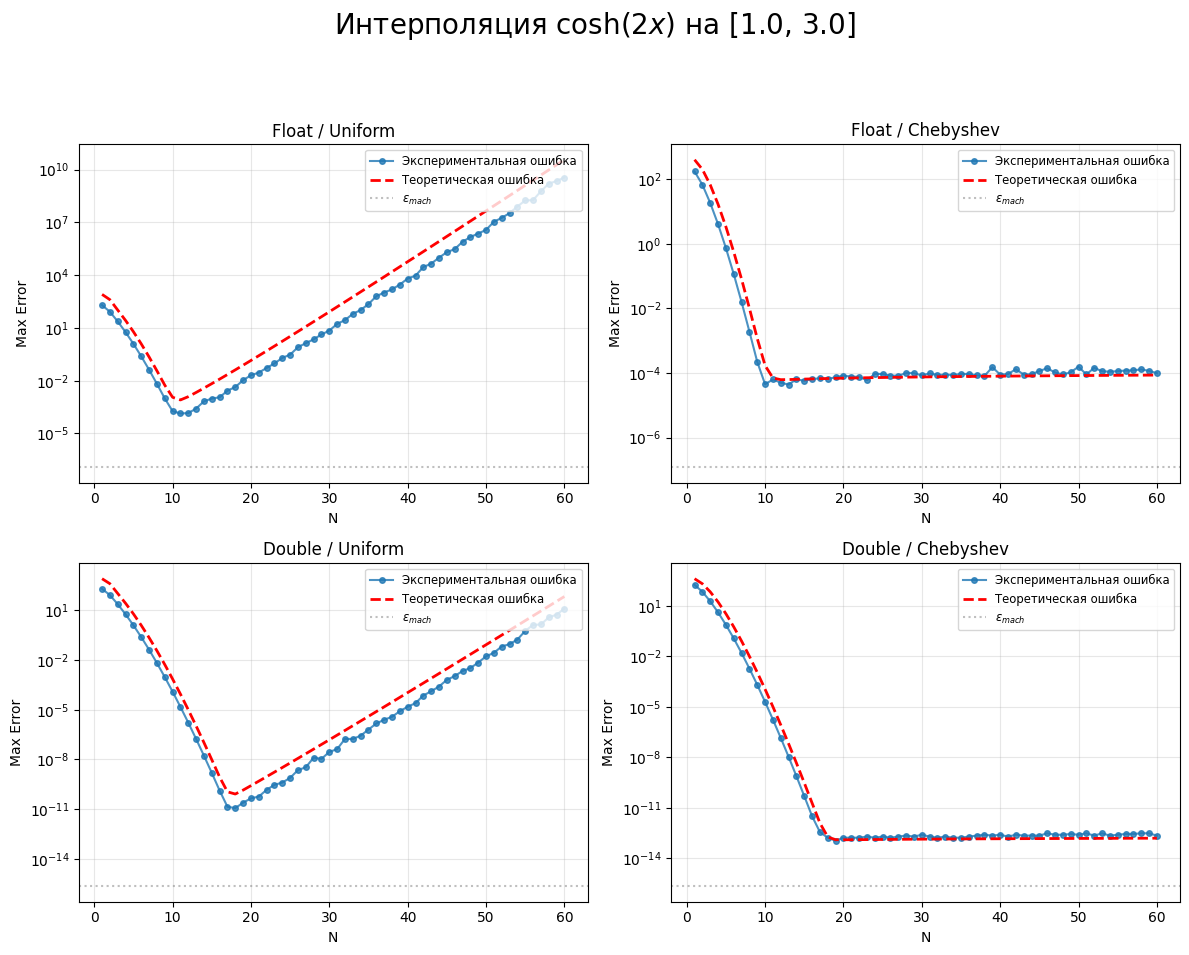

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial

N_GRID_MAX = 60
N_CHECK = 1000        
A, B = 1.0, 3.0       
FUNC = lambda x: np.cosh(2 * x) 

# Генерация узлов сетки
def get_nodes(n, grid_type, dtype):
    if grid_type == 'uniform':
        return np.linspace(A, B, n, dtype=dtype)
    elif grid_type == 'chebyshev':
        k = np.arange(1, n + 1)
        cheb_nodes = np.cos((2 * k - 1) * np.pi / (2 * n))
        return (0.5 * (A + B) + 0.5 * (B - A) * cheb_nodes).astype(dtype)

# Вычисление max|w(x)|
def max_w(n, nodes):
    x_fine = np.linspace(A, B, 5000)
    diffs = np.abs(x_fine[:, None] - nodes[None, :])
    w_vals = np.prod(diffs, axis=1)
    return np.max(w_vals)

# Вычисление интерполяционного многочлена Лагранжа
def lagrange_interpolation(x_nodes, y_nodes, x_eval, dtype):
    y_eval = np.zeros_like(x_eval, dtype=dtype)
    n = len(x_nodes)
    for i in range(n):
        term = np.ones_like(x_eval, dtype=dtype)
        for j in range(n):
            if i != j:
                term *= (x_eval - x_nodes[j]) / (x_nodes[i] - x_nodes[j])
        y_eval += y_nodes[i] * term
    return y_eval

# Расчет константы Лебега
def const_lebegue(nodes):
    n = len(nodes)
    if n == 0: return 0
    if n == 1: return 1
    
    # Сетка для поиска максимума функции Лебега
    num_fine_points = max(2000, 100 * n)
    x_fine = np.linspace(A, B, num_fine_points)
    
    # Инициализируем массив сумм модулей нулями
    # lambda_n(x) = sum_{i=0}^{n} |l_i(x)|
    sum_abs_basis = np.zeros(num_fine_points)
    
    for i in range(n):
        # Явный расчет i-го базисного полинома:
        
        l_i = np.ones_like(x_fine)
        
        for j in range(n):
            if i == j:
                continue
            
            # (x - x_j) / (x_i - x_j)
            numerator = x_fine - nodes[j]
            denominator = nodes[i] - nodes[j]
            
            l_i *= (numerator / denominator)
        
        # Добавляем |l_i(x)| к общей сумме
        sum_abs_basis += np.abs(l_i)
        
    # Константа Лебега - это максимум функции Лебега на интервале
    return np.max(sum_abs_basis)

# Расчет теоретической ошибки
def get_theoretical_error(n_values, grid_type, eps_machine):
    errors = []
    
    max_abs_f = np.cosh(2 * B) 

    for n in n_values:
        nodes = get_nodes(n, grid_type, np.float64)
        
        # Ошибка метода (Truncation)
        # max|f^(n)(x)| / n! * max|w(x)|
        max_deriv = (2.0 ** n) * np.cosh(2 * B)
        max_node_poly = max_w(n, nodes)
        truncation_err = (max_deriv / factorial(n)) * max_node_poly
        
        # Ошибка округления (Rounding)
        # eps * \Lambda_n * max|f(x)|
        lebesgue = const_lebegue(nodes)
        rounding_err = eps_machine * lebesgue * max_abs_f
        
        errors.append(truncation_err + rounding_err)
        
    return np.array(errors)

# Выполнение эксперимента
def run_experiment(dtype, grid_type):
    results_n = []
    results_err = []
    
    x_check = np.linspace(A, B, N_CHECK)
    y_true = FUNC(x_check)

    for n in range(1, N_GRID_MAX + 1):
        nodes = get_nodes(n, grid_type, dtype)
        y_nodes = FUNC(nodes).astype(dtype)
        
        # Считаем интерполяционный многочлен Лагранжа
        y_pred = lagrange_interpolation(nodes, y_nodes, x_check, dtype=dtype)
        
        err = np.max(np.abs(y_true - y_pred))
        results_n.append(n)
        results_err.append(err)
        
    return np.array(results_n), np.array(results_err)

# Построение графика
def plot_case(ax, dtype, grid_type, title, eps):
    n_vals, err_vals = run_experiment(dtype, grid_type)
    ax.semilogy(n_vals, err_vals, 'o-', markersize=4, label='Экспериментальная ошибка', alpha=0.8)
    
    # Получение теоретической ошибки
    theo_vals = get_theoretical_error(n_vals, grid_type, eps)
    ax.semilogy(n_vals, theo_vals, '--', linewidth=2, color='red', label='Теоретическая ошибка')
    
    ax.axhline(eps, color='gray', linestyle=':', alpha=0.5, label=fr'$\epsilon_{{mach}}$')
    
    ax.set_title(title)
    ax.set_xlabel("N")
    ax.set_ylabel("Max Error")
    ax.grid(True, which="both", alpha=0.3)
    ax.legend(fontsize='small', loc='upper right')

def main():
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(fr"Интерполяция $\cosh(2x)$ на [{A}, {B}]", fontsize=20)

    eps_float = 1.19e-07
    eps_double = 2.22e-16

    # Запускаем построение
    plot_case(axs[0, 0], np.float32, 'uniform', "Float / Uniform", eps_float)
    plot_case(axs[0, 1], np.float32, 'chebyshev', "Float / Chebyshev", eps_float)
    
    plot_case(axs[1, 0], np.float64, 'uniform', "Double / Uniform", eps_double)
    plot_case(axs[1, 1], np.float64, 'chebyshev', "Double / Chebyshev", eps_double)

    plt.tight_layout(rect=(0, 0.03, 1, 0.93))
    plt.show()

main()